## Imports and settings

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys
import json
import pprint

import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import ipywidgets as widgets
from matplotlib import gridspec
import pprint
from scipy.stats import gaussian_kde

detector_path = '..'
results_path = os.path.join(detector_path, 'results')
sys.path.append(detector_path)

from utils import constants
from utils import errors
from sleep.mass import MASS
from sleep.inta import INTA
from sleep import postprocessing
from sleep import data_ops
from evaluation import metrics
from evaluation import data_manipulation

DPI = 200

%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# BSF plots

In [79]:
dataset_name = constants.MASS_NAME

# ----
# Marks are binary sequences for each page, 200 fs resolution
errors.check_valid_value(
    dataset_name, 'dataset_name',
    [constants.MASS_NAME, constants.INTA_NAME])
if dataset_name == constants.MASS_NAME:
    dataset = MASS(load_checkpoint=True)
else:
    dataset = INTA(load_checkpoint=True)
print('Loading test set')
test_ids = dataset.test_ids
print('Testing set IDs:', test_ids)

# Get subjects data, with the expert used for training
verbose = False
print('Loading signals and marks')
x, y = dataset.get_subset_data(test_ids, which_expert=1, verbose=verbose)
print('Loading pages')
pages = dataset.get_subset_pages(test_ids, verbose=verbose)

# Prepare expert labels into marks
print('Preparing labels... ', end='', flush=True)
y_stamps = postprocessing.generate_mark_intervals_with_list(
    y, pages, 200, 200, thr=None, postprocess=False)
print('Done')

Dataset mass with 15 patients.
Train size: 11. Test size: 4
Train subjects: 
 [1, 3, 5, 7, 9, 10, 11, 14, 17, 18, 19]
Test subjects: 
 [2, 6, 12, 13]
Loading from checkpoint... Loaded
Loading test set
Testing set IDs: [2, 6, 12, 13]
Loading signals and marks
Loading pages
Preparing labels... Done


In [81]:
# thr for BSF:
#    MASS: run 0.4, avg 0.45
#    INTA: run 0.525, avg 0.475

ckpt_folder = os.path.join('20190408_bsf')
thr_avg = 0.45
thr_run = 0.4

n_runs = 4
avg_folder = 'avg'
run_folder = 'seed'
comparison_folder = 'comparison_data'

# ---
# Load predictions (probability vectors for each page), 200/factor resolution (default factor 8)
ckpt_path = os.path.abspath(os.path.join(
    results_path, 
    'predictions_%s' % dataset_name, 
    '%s_train_%s' % (ckpt_folder, dataset_name),
    'bsf'
))

# Load predictions
y_pred = {}
for k in range(n_runs):
    this_ckpt_id = '%s%d' % (run_folder, k)
    this_path = os.path.join(
        ckpt_path,
        this_ckpt_id
    )
    print('Loading predictions from %s' % this_path)
    y_pred[this_ckpt_id] = np.load(os.path.join(this_path, 'y_pred_test.npy'), allow_pickle=True)
    # Keep only class 1 probability
    y_pred[this_ckpt_id] = [this_y_pred[..., 1] for this_y_pred in y_pred[this_ckpt_id]]
    print('Done')
this_path = os.path.join(
    ckpt_path,
    avg_folder
)
print('Loading predictions from %s' % this_path)
y_pred[avg_folder] = np.load(os.path.join(this_path, 'y_pred_test.npy'), allow_pickle=True)
# Keep only class 1 probability
y_pred[avg_folder] = [this_y_pred[..., 1] for this_y_pred in y_pred[avg_folder]]
print('Done')

# Load f1 vs iou data
f1_vs_iou = {}
for k in range(n_runs):
    this_ckpt_id = '%s%d' % (run_folder, k)
    this_path = os.path.join(
        comparison_folder,
        '%s_f1_vs_iou_model_20190408_bsf_%s.csv' % (dataset_name, this_ckpt_id)        
    )
    print('Loading F1 data from %s' % this_path)
    f1_vs_iou[this_ckpt_id] = np.loadtxt(this_path, delimiter=",")
this_path = os.path.join(
    comparison_folder,
    '%s_f1_vs_iou_model_20190408_bsf_%s.csv' % (dataset_name, avg_folder)        
)
print('Loading F1 data from %s' % this_path)
f1_vs_iou[avg_folder] = np.loadtxt(this_path, delimiter=",")
# Compute mean of single runs
mean_single_runs = np.stack(
    [
        f1_vs_iou['%s%d' % (run_folder, i)] 
        for i in range(n_runs)
    ], axis=2).mean(axis=2)
f1_vs_iou['mean_runs'] = mean_single_runs

Loading predictions from /home/ntapia/projects/repos/ssdetection-rnn/detector/results/predictions_mass/20190408_bsf_train_mass/bsf/seed0
Done
Loading predictions from /home/ntapia/projects/repos/ssdetection-rnn/detector/results/predictions_mass/20190408_bsf_train_mass/bsf/seed1
Done
Loading predictions from /home/ntapia/projects/repos/ssdetection-rnn/detector/results/predictions_mass/20190408_bsf_train_mass/bsf/seed2
Done
Loading predictions from /home/ntapia/projects/repos/ssdetection-rnn/detector/results/predictions_mass/20190408_bsf_train_mass/bsf/seed3
Done
Loading predictions from /home/ntapia/projects/repos/ssdetection-rnn/detector/results/predictions_mass/20190408_bsf_train_mass/bsf/avg
Done
Loading F1 data from comparison_data/mass_f1_vs_iou_model_20190408_bsf_seed0.csv
Loading F1 data from comparison_data/mass_f1_vs_iou_model_20190408_bsf_seed1.csv
Loading F1 data from comparison_data/mass_f1_vs_iou_model_20190408_bsf_seed2.csv
Loading F1 data from comparison_data/mass_f1_vs_i

### F1 vs IoU (Test)

Detector         |   AF1   | F1(0.3) | F1(0.7) | F1(0.8)
Expert (mean)    |  66.65  |  74.19  |  62.79  |  48.72
DOSED            |  66.95  |  72.83  |  65.22  |  48.32
Ours (mean)      |  72.85  |  79.40  |  70.22  |  54.74
Ours (ensemble)  |  73.71  |  79.98  |  71.39  |  56.65


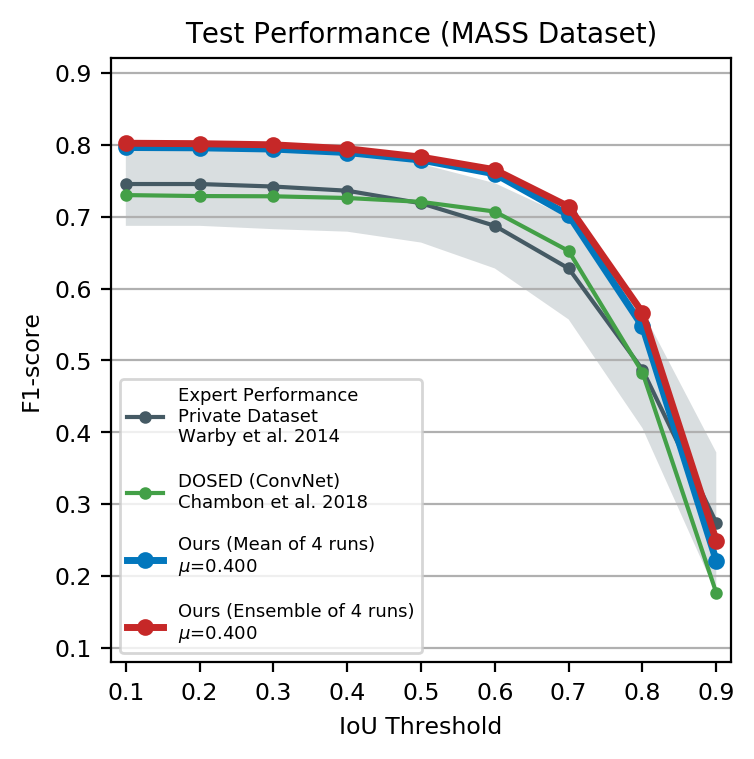

In [114]:
# ---- F1 vs IoU curve

compare_expert = True
compare_chambon = True
alpha = 0.2
color_list = {'model_avg': '#c62828', 'model_mean': '#0277bd' , 'expert': '#455a64', 'chambon': '#43a047'}
linewidth_model = 2.5
markersize_model = 10
linewidth_others = 1.5
markersize_others = 7

# -------------------- P L O T ----------------------    
# Comparison data
if compare_expert:
    expert_f1_curve_mean = np.loadtxt(os.path.join(comparison_folder, 'f1_vs_iou_expert_mean.csv'), delimiter=',')
    expert_f1_curve_std = np.loadtxt(os.path.join(comparison_folder, 'f1_vs_iou_expert_std.csv'), delimiter=',')
if compare_chambon:
    chambon_f1_curve = np.loadtxt(os.path.join(comparison_folder, 'mass_f1_vs_iou_Chambon.csv'), delimiter=',')

fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=DPI)

# Table 
print('Detector         |   AF1   | F1(0.3) | F1(0.7) | F1(0.8)')

# Complete plot
if compare_expert:
    ax.plot(expert_f1_curve_mean[1:, 0], expert_f1_curve_mean[1:, 1], linewidth=linewidth_others, 
               markersize=markersize_others, marker='.', 
               label='Expert Performance\nPrivate Dataset\nWarby et al. 2014', color=color_list['expert'])
    ax.fill_between(
        expert_f1_curve_mean[1:, 0], 
        expert_f1_curve_mean[1:, 1] - expert_f1_curve_std[1:, 1], 
        expert_f1_curve_mean[1:, 1] + expert_f1_curve_std[1:, 1], 
        alpha=alpha, facecolor=color_list['expert'])
    af1_expert = expert_f1_curve_mean[3:-1, 1].mean()
    print('Expert (mean)    |  %2.2f  |  %2.2f  |  %2.2f  |  %2.2f' 
      % (
          100*af1_expert, 
          100*expert_f1_curve_mean[3, 1], 
          100*expert_f1_curve_mean[7, 1],
          100*expert_f1_curve_mean[8, 1]
      ))
if compare_chambon and dataset_name == constants.MASS_NAME:
    ax.plot(chambon_f1_curve[:, 0], chambon_f1_curve[:, 1], linewidth=linewidth_others, 
               markersize=markersize_others, marker='.', 
               label='DOSED (ConvNet)\nChambon et al. 2018', color=color_list['chambon'])
    af1_chambon = chambon_f1_curve[2:-1, 1].mean()
    print('DOSED            |  %2.2f  |  %2.2f  |  %2.2f  |  %2.2f' 
      % (
          100*af1_chambon, 
          100*chambon_f1_curve[2, 1], 
          100*chambon_f1_curve[6, 1], 
          100*chambon_f1_curve[7, 1]))
ax.plot(f1_vs_iou['mean_runs'][:, 0], f1_vs_iou['mean_runs'][:, 1], 
           linewidth=linewidth_model, markersize=markersize_model, marker='.', 
           label='Ours (Mean of 4 runs)\n$\mu$=%1.3f' % thr_run, color=color_list['model_mean'])
af1_mean = f1_vs_iou['mean_runs'][2:-1, 1].mean()
print('Ours (mean)      |  %2.2f  |  %2.2f  |  %2.2f  |  %2.2f' 
      % (
          100*af1_mean, 
          100*f1_vs_iou['mean_runs'][2, 1], 
          100*f1_vs_iou['mean_runs'][6, 1], 
          100*f1_vs_iou['mean_runs'][7, 1]))

ax.plot(f1_vs_iou[avg_folder][:, 0], f1_vs_iou[avg_folder][:, 1], 
           linewidth=linewidth_model, markersize=markersize_model, marker='.', 
           label='Ours (Ensemble of 4 runs)\n$\mu$=%1.3f' % thr_run, color=color_list['model_avg'])
af1_avg = f1_vs_iou[avg_folder][2:-1, 1].mean()
print('Ours (ensemble)  |  %2.2f  |  %2.2f  |  %2.2f  |  %2.2f' 
      % (
          100*af1_avg, 
          100*f1_vs_iou[avg_folder][2, 1], 
          100*f1_vs_iou[avg_folder][6, 1], 
          100*f1_vs_iou[avg_folder][7, 1]))

ax.set_title('Test Performance (%s Dataset)' % dataset_name.upper(), fontsize=10)
ax.set_xlim([0.08, 0.92])
ax.set_ylim([0.08, 0.92])
ax.set_yticks([0.1*i for i in range(1, 10)])
ax.set_xticks([0.1*i for i in range(1, 10)])
ax.tick_params(labelsize=8.5)
ax.set_xlabel('IoU Threshold', fontsize=8.5)
ax.set_ylabel('F1-score', fontsize=8.5)
ax.yaxis.grid()
ax.legend(loc='lower left', labelspacing=1.5, fontsize=6.5)

plt.show()

### PR Curve (Test)

In [93]:
iou_thr = 0.3
thr_list_mean = np.unique(np.sort(np.array([thr_run, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])))
thr_list_avg = np.unique(np.sort(np.array([thr_avg, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])))

pr_curve = {}

# Single run
n_thr = len(thr_list_mean)
for k in range(n_runs):
    print('\nProcessing run %d' % k, flush=True)
    pr_curve['%s%d' % (run_folder, k)] = np.zeros((n_thr, 2)) 
    for i, thr in enumerate(thr_list_mean):
        print('Processing threshold %1.2f' % thr, flush=True)
        # Columns are [x: recall, y: precision]
        y_pred_thr = postprocessing.generate_mark_intervals_with_list(
            y_pred['%s%d' % (run_folder, k)], pages, 200//8, 200, thr=thr)
        this_stats = [metrics.by_event_confusion(this_y, this_y_pred, iou_thr=iou_thr) 
                    for (this_y, this_y_pred) in zip(y_stamps, y_pred_thr)]
        this_recall = np.mean([m['recall'] for m in this_stats])
        this_precision = np.mean([m['precision'] for m in this_stats])
        pr_curve['%s%d' % (run_folder, k)][i, 0] = this_recall
        pr_curve['%s%d' % (run_folder, k)][i, 1] = this_precision
# Ensemble
n_thr = len(thr_list_avg)
print('\nProcessing ensemble', flush=True)
pr_curve[avg_folder] = np.zeros((n_thr, 2)) 
for i, thr in enumerate(thr_list_avg):
    print('Processing threshold %1.2f' % thr, flush=True)
    # Columns are [x: recall, y: precision]
    y_pred_thr = postprocessing.generate_mark_intervals_with_list(
        y_pred[avg_folder], pages, 200//8, 200, thr=thr)
    this_stats = [metrics.by_event_confusion(this_y, this_y_pred, iou_thr=iou_thr) 
                for (this_y, this_y_pred) in zip(y_stamps, y_pred_thr)]
    this_recall = np.mean([m['recall'] for m in this_stats])
    this_precision = np.mean([m['precision'] for m in this_stats])
    pr_curve[avg_folder][i, 0] = this_recall
    pr_curve[avg_folder][i, 1] = this_precision
# Mean of runs
pr_curve['mean_runs'] = np.stack(
    [
        pr_curve['%s%d' % (run_folder, i)] 
        for i in range(n_runs)
    ], axis=2).mean(axis=2)
print('Done', flush=True)

Processing run 0
Processing threshold 0.10
Processing threshold 0.20
Processing threshold 0.30
Processing threshold 0.40
Processing threshold 0.50
Processing threshold 0.60
Processing threshold 0.70
Processing threshold 0.80
Processing threshold 0.90
Processing run 1
Processing threshold 0.10
Processing threshold 0.20
Processing threshold 0.30
Processing threshold 0.40
Processing threshold 0.50
Processing threshold 0.60
Processing threshold 0.70
Processing threshold 0.80
Processing threshold 0.90
Processing run 2
Processing threshold 0.10
Processing threshold 0.20
Processing threshold 0.30
Processing threshold 0.40
Processing threshold 0.50
Processing threshold 0.60
Processing threshold 0.70
Processing threshold 0.80
Processing threshold 0.90
Processing run 3
Processing threshold 0.10
Processing threshold 0.20
Processing threshold 0.30
Processing threshold 0.40
Processing threshold 0.50
Processing threshold 0.60
Processing threshold 0.70
Processing threshold 0.80
Processing threshold 0

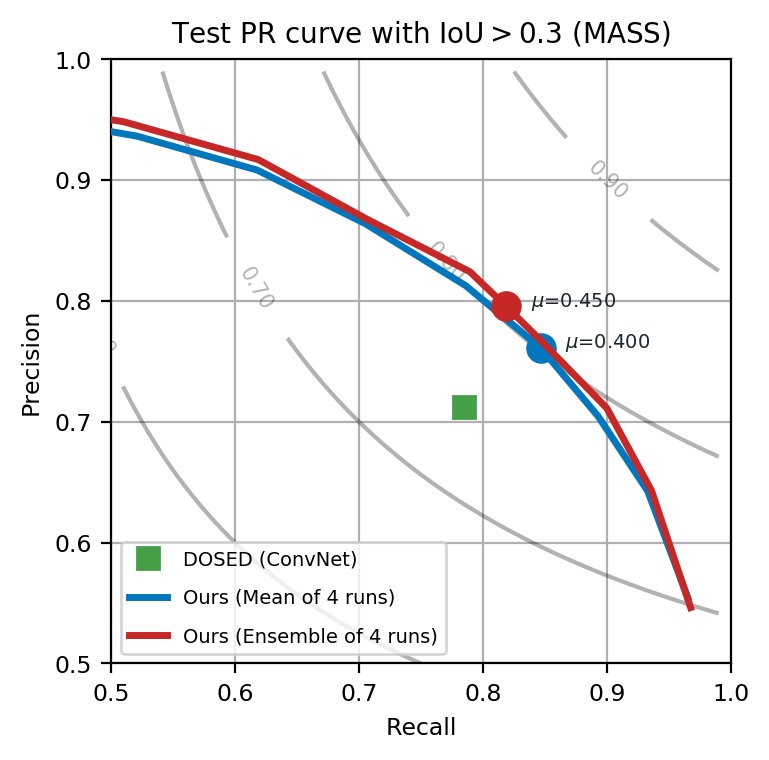

In [136]:
# Plot 
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=DPI)
markersize = 8
text_space = 0.01
compare_chambon = True
color_list = {'model_avg': '#c62828', 'model_mean': '#0277bd' , 'expert': '#455a64', 'chambon': '#43a047'}

# F1 score levels
delta = 0.01 
x_ = np.arange(1, 100) * delta 
y_ = np.arange(1, 100) * delta 
X, Y = np.meshgrid(x_, y_)
Z = 2 * X * Y / (X + Y)
CS = ax.contour(X, Y, Z, colors='k', alpha=0.3, levels=[0.6, 0.7, 0.8, 0.9])
ax.clabel(CS, fontsize=7.5, fmt='%1.2f')

# Chambon
if compare_chambon and dataset_name == constants.MASS_NAME:
    rec_prec = [0.784565916398714, 0.7120879120879123]
    ax.plot(rec_prec[0], rec_prec[1], 
           markersize=8, c=color_list['chambon'], zorder=10, 
            label='DOSED (ConvNet)', marker='s', linestyle="None")

# Mean of runs
ax.plot(pr_curve['mean_runs'][:, 0], pr_curve['mean_runs'][:, 1], 
        label='Ours (Mean of 4 runs)', markersize=markersize, # marker='.', 
        linewidth=2.5, color=color_list['model_mean'], zorder=10)
# Highlight chosen operating point
chosen_thr_idx = thr_list_mean.tolist().index(thr_run)
ax.scatter(pr_curve['mean_runs'][chosen_thr_idx, 0], pr_curve['mean_runs'][chosen_thr_idx, 1], 
           s=100, c=color_list['model_mean'], zorder=10)
ax.annotate('$\mu$=%1.3f' % thr_run, 
            (pr_curve['mean_runs'][chosen_thr_idx, 0] + text_space*2, 
             pr_curve['mean_runs'][chosen_thr_idx, 1]), 
            fontsize=7, color='#1b2631', zorder=30)  

# Ensemble
ax.plot(pr_curve[avg_folder][:, 0], pr_curve[avg_folder][:, 1], 
        label='Ours (Ensemble of 4 runs)', markersize=markersize, # marker='.', 
        linewidth=2.5, color=color_list['model_avg'], zorder=20)
# Highlight chosen operating point
chosen_thr_idx = thr_list_avg.tolist().index(thr_avg)
ax.scatter(pr_curve[avg_folder][chosen_thr_idx, 0], pr_curve[avg_folder][chosen_thr_idx, 1], 
           s=100, c=color_list['model_avg'], zorder=20)
ax.annotate('$\mu$=%1.3f' % thr_avg, 
            (pr_curve[avg_folder][chosen_thr_idx, 0] + text_space*2, 
             pr_curve[avg_folder][chosen_thr_idx, 1]), 
            fontsize=7, color='#1b2631', zorder=30)  

ax.set_title('Test PR curve with IoU$>$%1.1f (%s)' % (iou_thr, dataset_name.upper()), fontsize=10)
ax.set_xlabel('Recall', fontsize=8.5)
ax.set_ylabel('Precision', fontsize=8.5)
ax.set_xlim([0.5, 1])
ax.set_ylim([0.5, 1])
ax.legend(loc='lower left', labelspacing=1, fontsize=7)
ax.tick_params(labelsize=8.5)
ax.grid()
plt.show()

### Performance vs Train Size

In [121]:
if dataset_name == constants.INTA_NAME:
    raise ValueError('Only available for MASS dataset')

size_list = [1, 3, 5, 7]
n_runs = 4
perf_run_folder = 'run'
perf_avg_folder = 'avg'

perf_f1_vs_iou = {}
    
# Load f1 vs iou data
for size in size_list:
    print('\nLoading size %d' % size, flush=True)
    for k in range(n_runs):
        this_ckpt_id = 'size%d_%s%d' % (size, perf_run_folder, k)
        this_path = os.path.join(
            comparison_folder,
            '%s_f1_vs_iou_model_20190408_bsf_%s.csv' % (dataset_name, this_ckpt_id)        
        )
        print('Loading F1 data from %s' % this_path)
        perf_f1_vs_iou[this_ckpt_id] = np.loadtxt(this_path, delimiter=",")
    this_ckpt_id = 'size%d_%s' % (size, perf_avg_folder)
    this_path = os.path.join(
        comparison_folder,
        '%s_f1_vs_iou_model_20190408_bsf_%s.csv' % (dataset_name, this_ckpt_id)        
    )
    print('Loading F1 data from %s' % this_path)
    perf_f1_vs_iou[this_ckpt_id] = np.loadtxt(this_path, delimiter=",")
    # Compute mean of single runs
    mean_single_runs = np.stack(
        [
            perf_f1_vs_iou['size%d_%s%d' % (size, perf_run_folder, i)] 
            for i in range(n_runs)
        ], axis=2).mean(axis=2)
    perf_f1_vs_iou['size%d_mean_runs' % size] = mean_single_runs    
print('Done')


Loading size 1
Loading F1 data from comparison_data/mass_f1_vs_iou_model_20190408_bsf_size1_run0.csv
Loading F1 data from comparison_data/mass_f1_vs_iou_model_20190408_bsf_size1_run1.csv
Loading F1 data from comparison_data/mass_f1_vs_iou_model_20190408_bsf_size1_run2.csv
Loading F1 data from comparison_data/mass_f1_vs_iou_model_20190408_bsf_size1_run3.csv
Loading F1 data from comparison_data/mass_f1_vs_iou_model_20190408_bsf_size1_avg.csv

Loading size 3
Loading F1 data from comparison_data/mass_f1_vs_iou_model_20190408_bsf_size3_run0.csv
Loading F1 data from comparison_data/mass_f1_vs_iou_model_20190408_bsf_size3_run1.csv
Loading F1 data from comparison_data/mass_f1_vs_iou_model_20190408_bsf_size3_run2.csv
Loading F1 data from comparison_data/mass_f1_vs_iou_model_20190408_bsf_size3_run3.csv
Loading F1 data from comparison_data/mass_f1_vs_iou_model_20190408_bsf_size3_avg.csv

Loading size 5
Loading F1 data from comparison_data/mass_f1_vs_iou_model_20190408_bsf_size5_run0.csv
Loading 

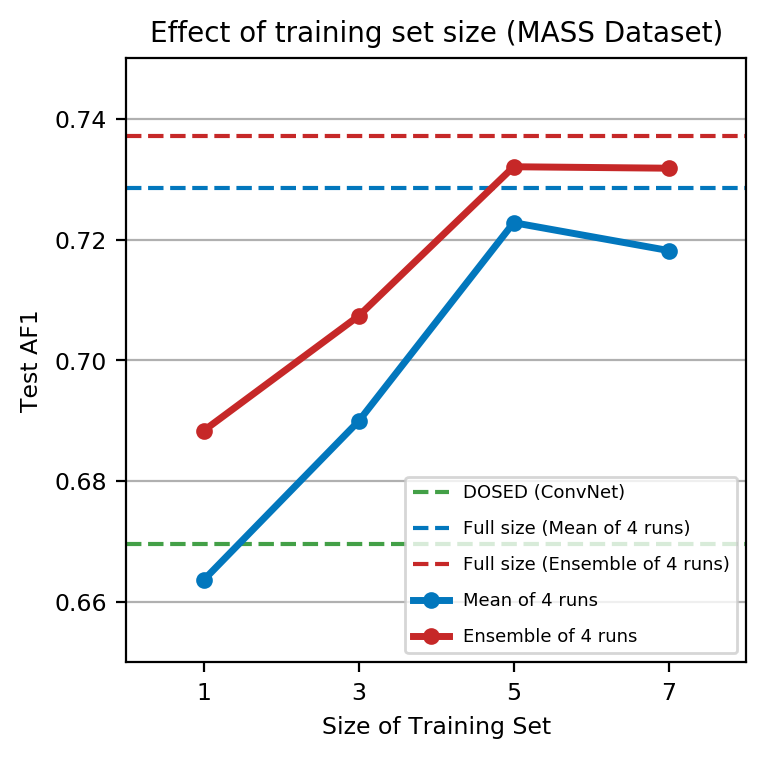

In [156]:
# Plot
compare_chambon = True

fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=DPI)
color_list = {'model_avg': '#c62828', 'model_mean': '#0277bd' , 'expert': '#455a64', 'chambon': '#43a047'}

# Complete plot
if compare_chambon and dataset_name == constants.MASS_NAME:
    ax.plot([0, 8], [af1_chambon, af1_chambon], linestyle='--', color=color_list['chambon'], label='DOSED (ConvNet)')

# Compare with bsf performance
ax.plot([0, 8], [af1_mean, af1_mean], linestyle='--', color=color_list['model_mean'], label='Full size (Mean of 4 runs)')
ax.plot([0, 8], [af1_avg, af1_avg], linestyle='--', color=color_list['model_avg'], label='Full size (Ensemble of 4 runs)')
    
# Mean of runs
ax.plot(
    size_list,
    [perf_f1_vs_iou['size%d_mean_runs' % k][2:-1, 1].mean() for k in size_list],
    linewidth=2.5, markersize=10, marker='.', color=color_list['model_mean'],
    label='Mean of 4 runs'
)

# Ensemble of runs
ax.plot(
    size_list,
    [perf_f1_vs_iou['size%d_%s' % (k, perf_avg_folder)][2:-1, 1].mean() for k in size_list],
    linewidth=2.5, markersize=10, marker='.', color=color_list['model_avg'],
    label='Ensemble of 4 runs'
)


ax.set_title('Effect of training set size (%s Dataset)' % dataset_name.upper(), fontsize=10)
ax.set_xlim([0, 8])
ax.set_ylim([0.65, 0.75])
# ax.set_yticks([0.1*i for i in range(1, 10)])
ax.set_xticks(size_list)
ax.tick_params(labelsize=8.5)
ax.set_xlabel('Size of Training Set', fontsize=8.5)
ax.set_ylabel('Test AF1', fontsize=8.5)
ax.yaxis.grid()
ax.legend(loc='lower right', labelspacing=1, fontsize=6.5)

plt.show()

In [141]:
perf_f1_vs_iou['size1_run0']

array([[0.1       , 0.72305773],
       [0.2       , 0.72265949],
       [0.3       , 0.72091911],
       [0.4       , 0.7116342 ],
       [0.5       , 0.70069062],
       [0.6       , 0.68036106],
       [0.7       , 0.63227999],
       [0.8       , 0.4797968 ],
       [0.9       , 0.18937903]])

In [146]:
perf_f1_vs_iou['size7_mean_runs'][2:-1, 1]

array([0.78201772, 0.77840606, 0.76913861, 0.75080203, 0.69722235,
       0.53157534])